In [70]:
import numpy as np
from IPython.display import Image
import json
import sqlite3
import photongraph as pg

See work by Vigliar et al for more details about postselected photonic graph state  generators https://arxiv.org/pdf/2009.08339.pdf

### Read in Graph State Recipe

In [71]:
conn = sqlite3.connect('graph_databases/graph_db_4P4D.db')
cursor = conn.cursor()

graph_hash = str(2985669187)
cursor.execute("SELECT edge_dict, recipe_unitary FROM graphs WHERE graph_hash=" + graph_hash)
graph_record = cursor.fetchall()[0]
conn.close()

graph_recipe = json.loads(graph_record[1])

### Graph State Recipe

In [72]:
graph_recipe

{'post_FLU': {'A': [['I', 'H'],
   ['I', 'I'],
   ['H', 'I'],
   ['SH', 'I'],
   ['Z', 'I']],
  'B': [['H', 'H'],
   ['I', 'I'],
   ['CZ_01'],
   ['I', 'H'],
   ['HSH', 'SH'],
   ['I', 'Z']],
  'C': [['H', 'H'],
   ['I', 'I'],
   ['CZ_01'],
   ['H', 'H'],
   ['HS', 'SH'],
   ['I', 'Z']],
  'D': [['H', 'H'],
   ['I', 'I'],
   ['CZ_01'],
   ['H', 'H'],
   ['HS', 'SH'],
   ['I', 'Z']]},
 'Z_proj': {'1': 0}}

### Photonic Circuit Schematic

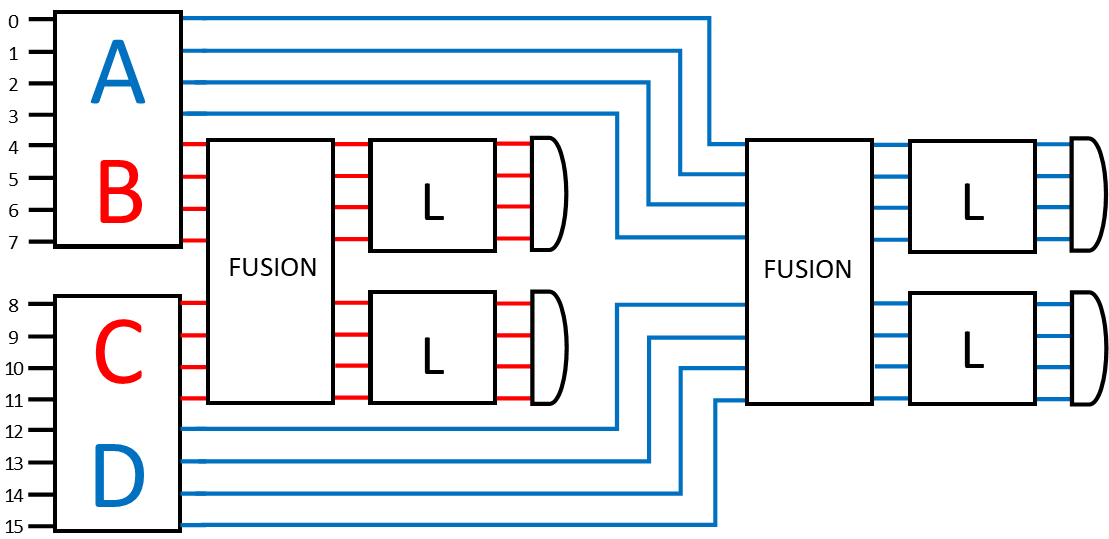

In [73]:
Image(filename = "4P4D_GSG.png", width=600, height=500)

### Build Photonic Circuit

In [74]:
qudit_dim = 4
qudit_num = 4

pGSG = pg.PostGSG(qudit_num, qudit_dim)
pGSG.add_op(('fusions',2), pg.Fusion((4,8), True))
pGSG.add_op(('fusions',2), pg.Fusion((5,9), True))

# Turn off these sources (indexed from 0) bysetting the squeezing parameter to zero
pGSG.config_op(('sources',0), 1, sf_params = {'tmsv_param':(0.0, 0.0)})
pGSG.config_op(('sources',0), 2, sf_params = {'tmsv_param':(0.0, 0.0)})
pGSG.config_op(('sources',0), 5, sf_params = {'tmsv_param':(0.0, 0.0)})
pGSG.config_op(('sources',0), 6, sf_params = {'tmsv_param':(0.0, 0.0)})

In [75]:
qudit_A_postFLU = pg.utils.compile_qudit_LU(qudit_dim,*graph_recipe['post_FLU']['A'])
qudit_B_postFLU = pg.utils.compile_qudit_LU(qudit_dim,*graph_recipe['post_FLU']['B'])
qudit_C_postFLU = pg.utils.compile_qudit_LU(qudit_dim,*graph_recipe['post_FLU']['C'])
qudit_D_postFLU = pg.utils.compile_qudit_LU(qudit_dim,*graph_recipe['post_FLU']['D'])

Z_projectors = graph_recipe['Z_proj']

In [76]:
pGSG.config_op(('postFLU', 3), 0, sf_params={'U': qudit_A_postFLU})
pGSG.config_op(('postFLU', 3), 1, sf_params={'U': qudit_B_postFLU})
pGSG.config_op(('postFLU', 3), 2, sf_params={'U': qudit_C_postFLU})
pGSG.config_op(('postFLU', 3), 3, sf_params={'U': qudit_D_postFLU})

### Compile

In [77]:
pGSG.compile()

### Generate Logical State Vector

In [78]:
state_vector = pGSG.run('qubit')

### Generate Graph State from State Vector

In [79]:
graph_state = pg.gs_from_sv(state_vector)

### Apply Z Measurements

In [80]:
for q, s in Z_projectors.items():
    graph_state.measure_Z(int(q), int(s))

### Visualise Graph State

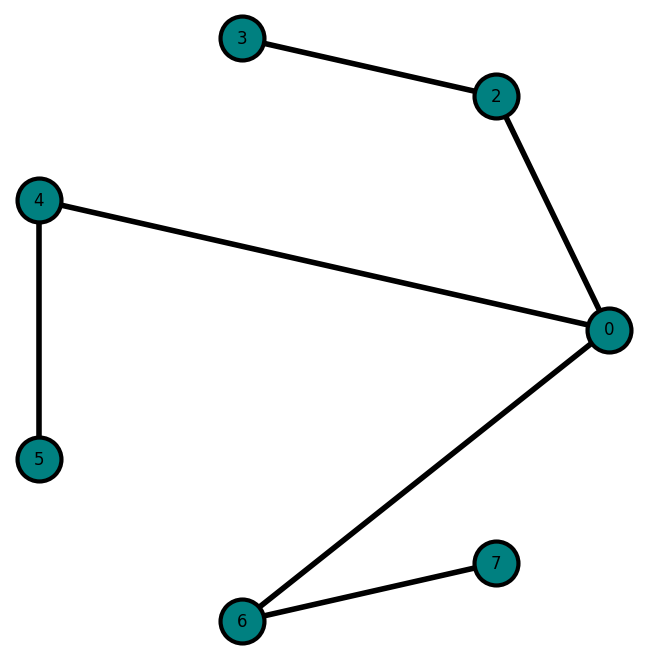

In [81]:
graph_state.draw()

### Estimate Coincidence Rate

In [82]:
# losses incurred per component in dB
component_losses = {"AMZI":1,
                    "crosser":0.2,
                    "grating_coupler":1.5,
                    "DC":0.0,
                    "MMI":0.5,
                    "off_chip_filter":2
                   }

# number of each component encounter on each mode
component_numbers = {"AMZI":1,
                    "crosser":8,
                    "grating_coupler":1,
                    "DC":0,
                    "MMI":8,
                    "off_chip_filter":1
                   }

# amount of propagation loss dB per cm
propagation_losses = {"chip":2.5,
                      "fibre":0.00002}

# propagation lenths in cm
propagation_lengths = {"chip":2.0,
                      "fibre":1500.0}

det_efficiency = 0.85

loss_params = {"component_losses": component_losses,
               "component_numbers": component_numbers,
               "propagation_losses": propagation_losses,
               "propagation_lengths": propagation_lengths,
               "det_efficiency": det_efficiency}


pGSG.coincidence_rate(loss_params)

'0.59954025 Hz'